In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pathlib
import random
import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [11]:
import librosa
import librosa.display
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchaudio import transforms

In [12]:
torch.manual_seed(0)
np.random.seed(0)

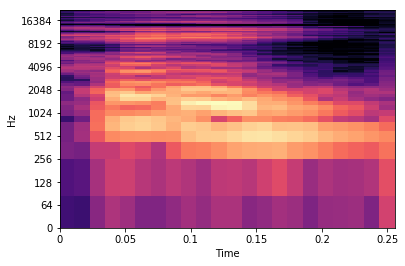

In [13]:
y, sr= librosa.core.load("./Record_1.wav", 44100)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_db = librosa.core.power_to_db(S)

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
librosa.display.specshow(S_db, y_axis='log', sr=sr, x_axis='time', ax=ax)

In [26]:
class CustomDataset(Dataset):
	def __init__(
		self, 
		wake_words_root_path = "D:/Workspace/Projects/Voice2Command/recordings/positive", 
		background_sounds_root_path = "D:/Storage/UrbanSound8K/audio/fold1",
		max_length = 3,
		sampling_rate = 44100 #44.1 Hz
		):
		self.wake_words_root_path = wake_words_root_path
		self.sampling_rate = sampling_rate
		self.background_sounds_root_path = background_sounds_root_path
		
		self.generated_samples = []
		self.sample_size = sampling_rate * max_length

		self.background_noise_sound_paths = list(pathlib.Path(background_sounds_root_path).glob('*.wav'))
		self.wake_words = self._load_wake_words(self.wake_words_root_path)

		#Spec Augment transforms
		self.transforms = nn.Sequential(
			transforms.FrequencyMasking(freq_mask_param=2),
			transforms.TimeMasking(time_mask_param=4)
		)

		for idx, path in enumerate(self.background_noise_sound_paths[:50]):
			y, sr = librosa.core.load(path, sr=sampling_rate)

			if len(y) < self.sample_size:
				y = np.pad(y, (0, self.sample_size - len(y)))
			else:
				y = y[:self.sample_size]

			y_false = np.array(y, copy=True)
			y_true = y

			wake_word = self.sample_wake_word()
			interval = self._get_random_time_interval(len(wake_word), max_length * sampling_rate)
			self._overlay_wakeword(y_true[interval[0]:interval[1]], wake_word)
			# self._save_sound(y)

			S_true = librosa.feature.melspectrogram(y=y_true, sr=sr)
			S_db_true = librosa.core.power_to_db(S_true)
			S_db_true = self.transforms(torch.from_numpy(S_db_true))

			S_false = librosa.feature.melspectrogram(y=y_false, sr=sr)
			S_db_false = librosa.core.power_to_db(S_false)
			S_db_false = self.transforms(torch.from_numpy(S_db_false))

			# Labels for position detection of the wake word
			# label = np.zeros(sample_size)
			# label[interval[1]:interval[1] + 50] = 1

			self.generated_samples.append(
				(S_db_true.unsqueeze(dim=0).float(), torch.tensor([1]).float())
			)

			self.generated_samples.append(
				(S_db_false.unsqueeze(dim=0).float(), torch.tensor([0]).float())
			)
				

	def __getitem__(self, idx):
		return self.generated_samples[idx]

	def _get_random_time_interval(self, interval_size, max_size):
		interval_start = np.random.randint(low=0, high=max_size - interval_size)
		interval_end = interval_start + interval_size

		return interval_start, interval_end

	def _overlay_wakeword(self, background, addition):
		background += addition
		background /= 2

	def _save_sound(self, data, name="generated_file.wav"):
		sf.write(name, data, self.sampling_rate)

	def __len__(self):
		return len(self.generated_samples)

	def _load_wake_words(self, wake_words_root_path):
		wake_word_paths = list(pathlib.Path(self.wake_words_root_path).glob('*.wav'))
		wake_words = []

		for idx, wake_word_path in enumerate(wake_word_paths):
			wake_word, _ = librosa.core.load(wake_word_path, sr=44100)
			
			if len(wake_word) > self.sample_size:
				raise Exception(f"Wake word size {len(wake_word)} bigger than the background noise max length {self.sample_size}")
		
			wake_word = np.pad(wake_word, (0, self.sampling_rate - len(wake_word)))
			wake_words.append(wake_word)

		return wake_words

	def sample_wake_word(self):
		return random.choice(self.wake_words)

In [27]:
dataset = CustomDataset()
sample = dataset[0][0]
print(sample.shape)

torch.Size([1, 128, 259])


In [28]:
class WakeWordCNNModel(nn.Module):
	def __init__(self, output_size, training = True):
		super().__init__()
		self.training = training

		self.conv_block1 = nn.Sequential(
			nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, padding=4),
			nn.MaxPool2d(kernel_size=2),
			nn.BatchNorm2d(16),
			nn.LeakyReLU(0.2, inplace=True),

			nn.Conv2d(in_channels=16, out_channels=16, kernel_size=4, padding=4),
			nn.MaxPool2d(kernel_size=2),
			nn.BatchNorm2d(16),
			nn.LeakyReLU(0.2, inplace=True)
		)
		
		self.conv_block2 = nn.Sequential(
			nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, padding=4),
			nn.MaxPool2d(kernel_size=2),
			nn.BatchNorm2d(32),
			nn.LeakyReLU(0.2, inplace=True),

			nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, padding=4),
			nn.MaxPool2d(kernel_size=2),
			nn.BatchNorm2d(32),
			nn.LeakyReLU(0.2, inplace=True)
		)


		self.l1 = nn.Linear(7680, 256)
		self.l2 = nn.Linear(256, output_size)

	def forward(self, input):
		out = self.conv_block1(input)
		out = self.conv_block2(out)

		# print(out.shape)
		out = out.view(out.size(0), -1)

		out = self.l1(out)
		out = F.leaky_relu(out)

		out = self.l2(out)
		out = F.sigmoid(out)

		return out

In [29]:
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)
model = WakeWordCNNModel(output_size=1)

# for i_batch, sample_batched in enumerate(dataloader):
#     data, labels = sample_batched

#     model(data.unsqueeze(dim=0))

In [30]:
EARLY_STOPPING_PATIENCE = 3
previous_epoch_loss = None
early_stopping_counter = 0

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
loss_criterion = torch.nn.BCELoss(size_average = True)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

training_dataset_size = len(dataset)
num_epochs = 50
device = torch.device("cuda")
model.to(device)

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)

    model = model.train()
    training_loss = []
    running_loss = 0.0
    running_corrects = 0
    

    for i, data in enumerate(tqdm(dataloader, desc=f"Epoch [{epoch + 1}] progress")):
        x_batch, label_batch = data
        x_batch, label_batch = x_batch.to(device), label_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)

        loss = loss_criterion(outputs, label_batch)

        loss.backward()
        optimizer.step()

        # statistics
        preds =  torch.round(outputs)
        running_loss += loss.item() * x_batch.size(0)
        running_corrects += torch.sum(preds == label_batch.detach())
#         print(preds)
#         print(label_batch)
#         break
        training_loss.append(loss.item())

    epoch_loss = running_loss / training_dataset_size
    epoch_acc = running_corrects.double() / training_dataset_size

    print('Training step => Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc
    ))

    scheduler.step(epoch_acc)

    if previous_epoch_loss is None:
        previous_epoch_loss = epoch_loss
    else:
        if epoch_loss > previous_epoch_loss:
            early_stopping_counter += 1
            previous_epoch_loss = epoch_loss
        else:
            early_stopping_counter = 0

    if early_stopping_counter == EARLY_STOPPING_PATIENCE:
        break

WakeWordCNNModel(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(32

Epoch [1] progress:   0%|          | 0/20 [00:00<?, ?it/s]Epoch 0/50
----------
Epoch [3] progress:   0%|          | 0/20 [00:00<?, ?it/s]Training step => Loss: 0.7616 Acc: 0.4700
Epoch 1/50
----------
Training step => Loss: 0.6506 Acc: 0.6100
Epoch 2/50
----------
Epoch [4] progress: 100%|██████████| 20/20 [00:00<00:00, 111.39it/s]Training step => Loss: 0.6070 Acc: 0.6200
Epoch 3/50
----------

Epoch [6] progress:   0%|          | 0/20 [00:00<?, ?it/s]Training step => Loss: 0.4748 Acc: 0.8300
Epoch 4/50
----------
Training step => Loss: 0.4034 Acc: 0.8500
Epoch 5/50
----------
Epoch [7] progress: 100%|██████████| 20/20 [00:00<00:00, 111.39it/s]Training step => Loss: 0.3759 Acc: 0.8500
Epoch 6/50
----------

Epoch [9] progress:   0%|          | 0/20 [00:00<?, ?it/s]Training step => Loss: 0.3008 Acc: 0.8900
Epoch 7/50
----------
Training step => Loss: 0.2299 Acc: 0.9600
Epoch 8/50
----------
Epoch [10] progress: 100%|██████████| 20/20 [00:00<00:00, 110.17it/s]Training step => Loss: 0.15

In [20]:
torch.save(model.state_dict(), f"model.pt")

In [29]:
def generate_sample(wake_word_path, background_path=None, duration_seconds=3, wake_word_duration_seconds = 2, sampling_rate=44100):
    sample_size = sampling_rate * duration_seconds
    interval_size = sampling_rate * wake_word_duration_seconds
	
    wake_word, _ = librosa.core.load(wake_word_path, sr=sampling_rate)
    print(len(wake_word))
    print(2 * sampling_rate)
    if len(wake_word) < 2 * sampling_rate:
        wake_word = np.pad(wake_word, (0, 2 * sampling_rate - len(wake_word)))
    else:
        wake_word = wake_word[: 2 * sampling_rate]

    generated_sample = None
    if background_path is not None:
        generated_sample, _ = librosa.core.load(background_path, sr=sampling_rate)
        if len(generated_sample) < sample_size:
            generated_sample = np.pad(generated_sample, (0, sample_size - len(generated_sample)))
        else:
            generated_sample = generated_sample[:sample_size]
    else:
        generated_sample = np.zeros((sample_size))

    interval_start = np.random.randint(low=0, high=sample_size - interval_size)
    interval_end = interval_start + interval_size

    generated_sample[interval_start:interval_end] += wake_word
    generated_sample /= 2
    return generated_sample

In [10]:
model = WakeWordCNNModel(output_size=1)
model.load_state_dict(torch.load("model.pt"))
model.eval()

<All keys matched successfully>

WakeWordCNNModel(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(16, 16, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(1, 1), padding=(4, 4))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(32

In [11]:
def predict(model, inputs):
    processed_inputs = []
    
    for data in inputs:
        S = librosa.feature.melspectrogram(y=data, sr=44100)
        S_db = librosa.core.power_to_db(S)
        processed_inputs.append(torch.from_numpy(S_db))

    inputs = torch.stack(processed_inputs)

    with torch.no_grad():
        inputs = torch.unsqueeze(inputs, 1)
        output = model(inputs)
    
    return output

In [37]:
generated_true_sample = generate_sample("Record_1.wav")
generated_true_sample = generated_true_sample.astype("float32")
# sf.write("sample.wav", generated_true_sample, 44100)
# generated_true_sample = np.expand_dims(generated_true_sample, 0)

false_sample, _ = librosa.core.load("false_sample.mp3", sr=44100)

if len(false_sample) > len(generated_true_sample):
    false_sample = false_sample[:len(generated_true_sample)]
else:
    false_sample = np.pad(false_sample, (0, len(generated_true_sample) - len(false_sample)))
# false_sample = np.expand_dims(false_sample, 0)

print(len(generated_true_sample))
print(len(false_sample))


output = predict(model, [false_sample, generated_true_sample])
torch.round(output)

132096
88200
132300
132300


tensor([[0.],
        [0.]])